# Resolviendo sistemas de ecuaciones lineales

En su forma más general un sistema de ecuaciones lineales se ve como

$$
\begin{align}
A_{11} x_{1} + A_{12} x_{2} + \ldots + A_{1M} x_M &= b_1 \nonumber \\
A_{21} x_{1} + A_{22} x_{2} + \ldots + A_{2M} x_M &= b_2  \nonumber \\
&\vdots  \nonumber \\
A_{N1} x_{1} + A_{N2} x_{2} + \ldots + A_{NM} x_M &= b_N  \nonumber \\
\end{align}
$$

donde 

- $A_{ij}$ y $b_i$ son los coeficientes del sistema
- $N$ es la cantidad de ecuaciones del sistema
- $M$ es la cantidad de incógnitas del sistema

El sistema anterior puede escribirse de forma matricial como

$$
A x = b
$$

donde $A \in \mathbb{R}^{N \times M}$ y $b \in \mathbb{R}^N$ 

Revisemos a continuación como se resuelven problemas de este tipo utilizando `scipy.linalg` 



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.linalg

## Solución de un sistema cuadrado 


Este es un caso particular donde la matriz $A$ tiene igual número de filas y columnas ($N=M$)

Asumiendo que la inversa de $A$ existe podemos resolver este sistema como

$$
\begin{align}
A x &=  b \nonumber \\
A^{-1} A x &= A^{-1} b \nonumber \\
x &= A^{-1} b \nonumber 
\end{align}
$$

donde $A A^{-1} = I$

A continuación veremos como calcular la inversa de una matriz y resolver el sistema de ecuaciones cuadrado

**Ejemplo** Sea el sistema de tres ecuaciones y tres incognitas

$$
\begin{align}
x_1 - 2x_2 + 3x_3 &= 4 \\
2x_1 - 5x2 + 12x_3 &= 15 \\
2x_2 - 10x_3 &= -10 
\end{align}
$$

que podemos reescribir como

$$
\begin{pmatrix}
1 & -2 & 3 \\
2 & -5 & 12 \\
0 & 2 & -10
\end{pmatrix} \cdot
\begin{pmatrix}
x_1 \\ x_2 \\ x_3
\end{pmatrix} =
\begin{pmatrix}
4 \\
15 \\
-10
\end{pmatrix} 
$$

de donde es directo identificar $A$ y $b$

In [2]:
A = np.array([[1, -2, 3], [2, -5, 12], [0, 2, -10]])
b = np.array([4, 15, -10])

Dado que $A$ es una matriz cuadrada podemos intentar invertla la función [`inv`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.inv.html#scipy.linalg.inv)

In [3]:
Ainv = scipy.linalg.inv(A)
Ainv

array([[-13. ,   7. ,   4.5],
       [-10. ,   5. ,   3. ],
       [ -2. ,   1. ,   0.5]])

Con la inversa podemos resolver el problema con

In [4]:
np.dot(Ainv, b)

array([8., 5., 2.])

:::{note}

Si $A$ hubiera sido singular, es decir no invertible, la función `inv` hubiera retornado un `LinAlgError`

:::

Podemos verificar la invertibilidad de la matriz comprobando que su determinante sea distinto de cero

In [5]:
scipy.linalg.det(A)

-1.9999999999999976

Otra forma de verificar si una matriz es invertible es comprobar que todas sus columnas sean linealmente independientes (LI)

Esto es equivalente a que su rango sea igual al número de columnas, lo cual se puede verificar con la función de `NumPy`

In [6]:
np.linalg.matrix_rank(A) == A.shape[1]

True

**Resolviendo sistemas cuadrados eficientemente**

En general si sólo nos interesa $x$, podemos no realizar el cálculo explícito de  $A^{-1}$. Si un sistema de ecuaciones es grande es preferible no calcular la inversa de $A$ debido al alto costo computacional necesario

Podemos encontrar $x$ directamente en un sistema cuadrado usando la función [`solve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html#scipy.linalg.solve)

In [7]:
scipy.linalg.solve(A, b)

array([8., 5., 2.])

El resultado es idéntico al anterior

Veamos ahora la diferencia en eficiencia utilizando un sistema más grande

In [8]:
N = 2000
A_big = np.random.rand(N, N) # Matriz cuadrada
b_big = np.random.rand(N, 1) # Vector
%timeit -r5 -n5 np.dot(scipy.linalg.inv(A_big), b_big)
%timeit -r5 -n5 scipy.linalg.solve(A_big, b_big)

297 ms ± 15.7 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
193 ms ± 11.6 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [9]:
np.allclose(scipy.linalg.solve(A_big, b_big), np.dot(scipy.linalg.inv(A_big), b_big))

True

Usar `solve` toma un poco más de la mitad del tiempo de utilizar `inv`+`dot`

¿Cómo puede ser posible esto? 

La respuesta es que `solve` realiza internamente una factorización del tipo

$$
\begin{align}
A x &= b \nonumber \\
LU x &= b \nonumber \\
L z &= b \nonumber
\end{align}
$$

Donde $L$ es una matriz triangular inferior (lower) y $U$ es una matriz triangular superior (upper)

$$
L = \begin{pmatrix} 
l_{11} & 0 & 0 & \ldots & 0 & 0 \\ 
l_{21} & l_{22} & 0 &\ldots & 0 & 0 \\ 
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
l_{N1} & l_{N2} & l_{N3} & \ldots & l_{N(N-1)} & l_{NN} \\ 
\end{pmatrix} \quad
U = \begin{pmatrix} 
u_{11} & u_{11} & u_{13} & \ldots & u_{1(N-1)} & u_{1N} \\ 
u_{21} & u_{22} & u_{32} &\ldots & u_{2(N-1)} & 0 \\ 
\vdots & \vdots & \vdots &\ldots & \ddots & \vdots \\
u_{N1} & 0 & 0 & \ldots & 0 & 0\\ 
\end{pmatrix}
$$

Luego $z$ se puede obtener recursivamente

$$
z_1 = \frac{b_1}{l_{11}}
$$
$$
z_2 = \frac{b_2 - l_{21} z_1}{l_{22}}
$$
$$
z_i = \frac{b_i - \sum_{j=1}^{i-1} l_{ij} z_j}{l_{ii}}
$$

y $x$ se puede obtener recursivamente de $z$

En caso de necesitar los factores LU podemos realizar la factorización en `scipy` con [`linalg.lu`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu.html#scipy.linalg.lu)

In [10]:
P, L, U = scipy.linalg.lu(A)
L, U

(array([[1.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  ],
        [0.5 , 0.25, 1.  ]]),
 array([[  2. ,  -5. ,  12. ],
        [  0. ,   2. , -10. ],
        [  0. ,   0. ,  -0.5]]))

## Solución de un sistema rectangular 


Consideremos que

- Las incógnitas de un sistema representan sus grados de libertad
- Las ecuaciones de un sistema representan sus restricciones

Si tenemos un sistema 

- con más ecuaciones que incógnitas ($N>M$): el sistema está sobredeterminado 
- con más incógnitas que ecuaciones ($M>N$): el sistema está infradeterminado

:::{warning}

En ambos casos la matriz $A$ ya no es cuadrada, es decir ya no podemos calcular la inversa

:::

Sin embargo podemos utilizar otros métodos, como mostraremos a continuación

**Caso N>M**

Sea el vector de error $e = Ax - b$ de un sistema con más ecuaciones que incognitas. 

Podemos encontrar una solución aproximada minimizando la norma euclidiana del error

$$
\begin{align}
\hat x &= \min_x \|e\|_2^2 \nonumber \\
& = \min_x e^T e \nonumber \\
& = \min_x (Ax -b)^T (Ax -b) \nonumber \\
\end{align}
$$

Lo cual se conoce como el **Problema de mínimos cuadrados**

Para continuar tomamos la última expresión y derivamos con respecto a $x$

$$
\begin{align}
\frac{d}{dx}  (A x - b)^T (A x -b) &= 2 A^T (A x -b) \nonumber \\
&= 2A^T A x - 2A^T b = 0 \nonumber \\
\rightarrow \hat x &= (A^T A)^{-1} A^T b \nonumber \\
&= A^{\dagger} b \nonumber \\
\end{align}
$$

donde $A^{\dagger} = (A^T A)^{-1} A^T$ se conoce como la pseudo-inversa de [Moore-Penrose](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse)

**Caso M>N**

La consecuencia de que el sistema sea infradeterminado es que $A^T A$ no es invertible. 

Para resolver el problema infradeterminado se debe agregar una restricción adicional. La más típica es que el vector solución tenga norma mínima, por ejemplo

$$
\min_\theta \| x \|_2^2 ~\text{s.a.}~ Ax =b
$$

que se resuelve usando $M$ [multiplicadores de Lagrange](https://es.wikipedia.org/wiki/Multiplicadores_de_Lagrange) $\lambda$ como sigue

$$
\begin{align}
\frac{d}{dx} \| x\|_2^2 + \lambda^T (b - Ax) &= 2x - \lambda^T A  \nonumber \\
&= 2Ax - A A^T \lambda \nonumber \\
&= 2b - A A^T \lambda = 0 
\end{align}
$$

De donde obtenemos que 

$$
\lambda = 2(AA^T)^{-1}b
$$ 

y por lo tanto 

$$
\hat x = \frac{1}{2} A^T \lambda = A^T (A A^T)^{-1} b,
$$

donde $A^T (A A^T)^{-1}$ se conoce como la pseudo-inversa "por la derecha"

**Resolviendo el sistema rectangular con Python**

Sea un sistema de ecuaciones lineales con $N\neq M$. Podemos usar scipy para

- Calcular la matriz pseudo inversa: [`scipy.linalg.pinv`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.pinv.html)
- Obtener la solución del sistema directamente: [`scipy.linalg.lstsq`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html)

Si $N>M$ se utiliza la pseudoinversa por la izquierda y la solución de mínimos cuadrados. En cambio si $M>N$ se utiliza la pseudoinversa para la derecha y la solución de multiplicadores de Lagrange

**Ejemplo:** Sea el siguiente set de datos de un estudio realizado en los años 50

Referencia: [A handbook of small datasets](https://www.routledge.com/A-Handbook-of-Small-Data-Sets/Hand-Daly-McConway-Lunn-Ostrowski/p/book/9780367449667)

In [11]:
df = pd.read_csv('data/helados.csv', index_col=0)
df.head()

,cons,income,price,temp
1,0.386,78,0.270,41
2,0.374,79,0.282,56
3,0.393,81,0.277,63
4,0.425,80,0.280,68
5,0.406,76,0.272,69


donde cada fila corresponde a un día las columnas corresponde a 

- consumo de helados promedio ([pintas](https://en.wikipedia.org/wiki/Pint) per capita)
- ingreso familiar promedio (dolares)
- temperatura promedio (grados Fahrenheit)
- precio promedio de los helados (dolares)

Ahora consideremos la siguiente pregunta

> ¿Está el consumo de helados influenciado por la temperatura?

Intentemos responder esta pregunta en base al siguiente modelo

$$
\text{cons} = \theta_0 + \theta_1 \cdot \text{temp}
$$

que corresponde a un sistema de ecuaciones lineales de dos incognitas y 

In [12]:
f"{len(df)} ecuaciones"

'30 ecuaciones'

Es decir que es un sistema sobredeterminado

$$
\begin{pmatrix}
cons[0] \\ cons[1] \\ \vdots \\ cons[{29}]
\end{pmatrix} = 
\begin{pmatrix}
1&temp[0] \\ 1&temp[1] \\ \vdots & \vdots \\ 1 & temp[29]
\end{pmatrix} 
\begin{pmatrix}
\theta_0 \\ \theta_1
\end{pmatrix} 
$$

que podemos resolver utilizando `lstsq`

In [13]:
A = np.ones(shape=(len(df), 2))
A[:, 1] = df["temp"].values
b = df["cons"].values

theta, residuals, rank, s = scipy.linalg.lstsq(A, b)
theta

array([0.20686215, 0.00310736])

La tupla retornada contiene

- `theta`: El resultado buscado
- `residuals`: La norma del error al cuadrado
- `rank`: El rango de $A$
- `s`: Los valores singulares de $A$

Analicemos gráficamente la solución obtenida

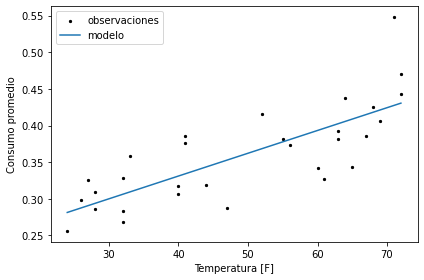

In [14]:
fig, ax = plt.subplots(tight_layout=True)
ax.scatter(df["temp"], df["cons"], s=5, c='k', label='observaciones')
ax.set_xlabel('Temperatura [F]')
ax.set_ylabel('Consumo promedio')
temp_modelo = np.linspace(df["temp"].min(), df["temp"].max(), num=200)
cons_modelo = temp_modelo*theta[1] + theta[0]
ax.plot(temp_modelo, cons_modelo, label='modelo')
ax.legend();

De donde podemos observar que el consumo promedio tiende al alza con la temperatura promedio

:::{note}

Lo que acabamos de resolver es un problema conocido como **regresión lineal**. Más adelante veremos una forma más general de este problema

:::

## Análisis de errores y *condition number*

Incluso aunque una matriz sea matemáticamente invertible (determinante distinto de cero), podríamos no ser capaces de resolver el problema numéricamente

Imaginemos una pequeña variación en $b$ denominada $\delta b$. Esta variación provoca a su vez una pequeña variación en $x$ denominada $\delta x$

Se puede encontrar una cota que compara el error relativo de $b$ y $x$ como

$$
\frac{\| \delta x \|}{\|x\|} \leq \frac{\| A^{-1} \|  \|\delta b\|}{\|x\|}  = \|A^{-1}\| \|A\| \frac{\| \delta b \|}{\|b\|} 
$$

donde se usó que $A \delta x = \delta b$ (propiedad de linealidad)

:::{note}

Esto significa que un pequeño error relativo en $b$ puede causar un gran error en $x$ 

:::

El estimador de $\|A^{-1}\| \|A\|$ es lo que se conoce como *condition number*

Un sistema se dice "bien condicionado" si este valor es cercano a $1$ y "mal condicionado" si es mucho mayor que $1$.

Podemos calcular el *condition number* con la función de NumPy `cond` como se muestra a continuación

```python
np.linalg.cond(x, # Arreglo multidimensional
               p # El orden de la norma: 1, 2, 'fro',...
              )
```
